<a href="https://colab.research.google.com/github/mPande92/Data-Exploration-in-python/blob/master/PySparkipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Exploration using PySpark

Using open-source data about open food facts data from website https://us.openfoodfacts.org/data

In [ ]:
!pip install pyspark
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [34]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, isnull, col, round, lit

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sc = SparkSession.builder.master("local").appName("Test").getOrCreate()

Read Data
Here, spark does not load full data initially until a command is prompted

In [5]:
base_df = sc.read.option("delimiter", "\t").option("header", "true").csv("/content/en.openfoodfacts.org.products.csv.gz")

Check the data

In [6]:
base_df.show()

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+----------------+--------------+---------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-----------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+-----------

In [7]:
base_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- last_modified_by: string (nullable = true)
 |-- last_updated_t: string (nullable = true)
 |-- last_updated_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_e

### Number of products per country

In [9]:
products_by_country = base_df.groupBy('countries').count()
products_by_country.printSchema()

root
 |-- countries: string (nullable = true)
 |-- count: long (nullable = false)



In [16]:
products_by_country.describe().show()

+-------+----------+------------------+
|summary| countries|             count|
+-------+----------+------------------+
|  count|      1989|              1990|
|   mean|      NULL|239.70251256281406|
| stddev|      NULL| 5228.927106175125|
|    min|Afganistán|                 1|
|    max|      香港|            204721|
+-------+----------+------------------+



In [17]:
country_df = products_by_country.filter(col('count')>=500).persist()
country_df.count()

26

Plot data

<Axes: xlabel='count', ylabel='countries'>

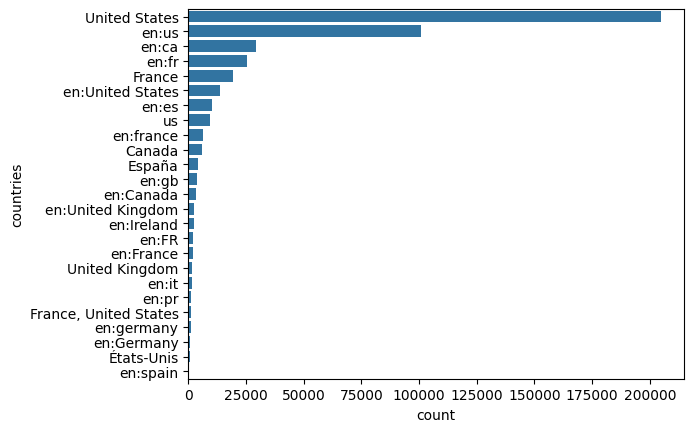

In [22]:
sns.barplot(data=country_df.toPandas().sort_values(by='count', ascending=False), x='count', y='countries', orient='h')

Take only USA

In [24]:
us_df = base_df.filter((col('countries') == 'United States')|(col('countries')=='en:us'))

count number of nulls in each column

In [26]:
us_df.count()

305596

In [25]:
us_df.select([count(when(isnull(c),c)).alias(c) for c in us_df.columns]).show()

+----+---+-------+---------+----------------+---------------+----------------------+----------------+--------------+---------------------+------------+------------------------+------------+--------+---------+--------------+------------+--------------+------+-----------+----------+---------------+-------------+-------+------------+----------+--------------------+-------------------------+------+-----------+---------+---------+--------------+------------------------+------+-----------+---------------+------+---------+--------------+------------+----------------+----------------+-------------------------+---------+------------+------+-----------+---------+------------+----------------+-----------------+-----------+---------+--------------+------------+----------------+----------------+----------+-------------+-------------+-----------+----------------+--------------+------+-----------+---------+-----------+--------------+--------------+--------------------+----------------+------+--------

In [39]:
null_count_df = base_df.select([(count(when(isnull(c),c))/count(lit(1))).alias(c) for c in base_df.columns])
null_count_df.show()

+----+---+-------+---------+----------------+---------------+----------------------+--------------------+--------------------+---------------------+--------------------+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+-------------------------+------------------+------------------+------------------+------------------+------------------+------------------------+------+------------------+------------------+------------------+--------------------+--------------------+--------------------+-----------------+-------------------+-------------------------+------------------+------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+---------+------

Remove columns not useful

In [40]:
filt_cols = ['categories', 'countries', 'serving_size', 'additives_n', 'nutriscore_grade', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
             'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
             'sodium_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g']

In [41]:
col_filt_df = base_df.select([c for c in base_df.columns if c in filt_cols])
col_filt_df.show(5)

+--------------------+---------+------------+-----------+----------------+-----------+--------+------------------+--------------+----------------+------------------+-----------+----------+-------------+---------+-----------+------------+---------+-----------------------+
|          categories|countries|serving_size|additives_n|nutriscore_grade|energy_100g|fat_100g|saturated-fat_100g|trans-fat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|salt_100g|sodium_100g|calcium_100g|iron_100g|nutrition-score-fr_100g|
+--------------------+---------+------------+-----------+----------------+-----------+--------+------------------+--------------+----------------+------------------+-----------+----------+-------------+---------+-----------+------------+---------+-----------------------+
|Aliments et boiss...|en:france|        NULL|       NULL|         unknown|       NULL|    NULL|              NULL|          NULL|            NULL|              NULL|       NULL|      N

In [43]:
filt_df = col_filt_df.dropna(how='all')
filt_df.count()

476685

In [45]:
filt_df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- serving_size: string (nullable = true)
 |-- additives_n: string (nullable = true)
 |-- nutriscore_grade: string (nullable = true)
 |-- energy_100g: string (nullable = true)
 |-- fat_100g: string (nullable = true)
 |-- saturated-fat_100g: string (nullable = true)
 |-- trans-fat_100g: string (nullable = true)
 |-- cholesterol_100g: string (nullable = true)
 |-- carbohydrates_100g: string (nullable = true)
 |-- sugars_100g: string (nullable = true)
 |-- fiber_100g: string (nullable = true)
 |-- proteins_100g: string (nullable = true)
 |-- salt_100g: string (nullable = true)
 |-- sodium_100g: string (nullable = true)
 |-- calcium_100g: string (nullable = true)
 |-- iron_100g: string (nullable = true)
 |-- nutrition-score-fr_100g: string (nullable = true)



In [ ]:
model_df = filt_df.select([])